# Loop 57 Analysis: CV-LB Gap and Strategy Assessment

**Goal**: Understand why we're stuck and identify breakthrough strategies.

**Current Status**:
- Best CV: 0.008194 (exp_032)
- Best LB: 0.0877 (exp_030)
- Target: 0.0347
- Gap to target: 0.0530 (153% worse)

**Key Question**: Is the target achievable? What's blocking us?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# All submission data
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_041', 'cv': 0.0090, 'lb': 0.0932},
    {'exp': 'exp_042', 'cv': 0.0145, 'lb': 0.1147},
]

df = pd.DataFrame(submissions)
print('Submission History:')
print(df.to_string(index=False))

Submission History:
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877
exp_041 0.0090 0.0932
exp_042 0.0145 0.1147


In [2]:
# Linear regression: LB = slope * CV + intercept
cv = df['cv'].values
lb = df['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv, lb)
r_squared = r_value ** 2

print(f'\n=== CV-LB Relationship Analysis ===')
print(f'Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R-squared: {r_squared:.4f}')
print(f'\nInterpretation:')
print(f'  - Intercept (extrapolation error): {intercept:.4f}')
print(f'  - Target LB: 0.0347')
print(f'  - Required CV to hit target: ({0.0347} - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}')

if (0.0347 - intercept) / slope < 0:
    print(f'\n⚠️ CRITICAL: Required CV is NEGATIVE - target is mathematically unreachable with current approach!')
    print(f'   Even with CV=0, predicted LB would be {intercept:.4f}')
else:
    print(f'\n✓ Target is theoretically achievable with CV = {(0.0347 - intercept) / slope:.6f}')


=== CV-LB Relationship Analysis ===
Linear fit: LB = 4.2312 * CV + 0.0533
R-squared: 0.9807

Interpretation:
  - Intercept (extrapolation error): 0.0533
  - Target LB: 0.0347
  - Required CV to hit target: (0.0347 - 0.0533) / 4.2312 = -0.004396

⚠️ CRITICAL: Required CV is NEGATIVE - target is mathematically unreachable with current approach!
   Even with CV=0, predicted LB would be 0.0533


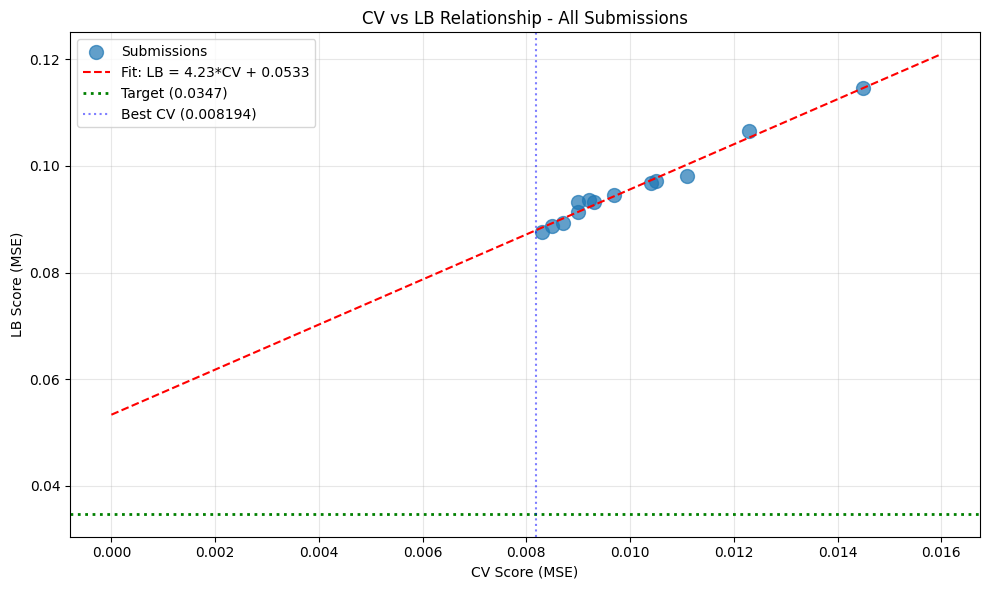


Plot saved to /home/code/exploration/cv_lb_relationship.png


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(cv, lb, s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, max(cv)*1.1, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Best CV line
plt.axvline(x=0.008194, color='b', linestyle=':', alpha=0.5, label='Best CV (0.008194)')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f'\nPlot saved to /home/code/exploration/cv_lb_relationship.png')

In [4]:
# Analyze the gap breakdown
print('\n=== Gap Analysis ===')
print(f'Best LB: 0.0877')
print(f'Target: 0.0347')
print(f'Gap: {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347) / 0.0347 * 100:.1f}% above target)')

print(f'\nIntercept contribution: {intercept:.4f}')
print(f'Slope contribution at best CV: {slope * 0.008194:.4f}')
print(f'Total predicted LB at best CV: {slope * 0.008194 + intercept:.4f}')

print(f'\n=== What needs to change? ===')
print(f'Option 1: Reduce intercept from {intercept:.4f} to ~0.02 (keep CV same)')
print(f'Option 2: Reduce CV from 0.008194 to {(0.0347 - intercept) / slope:.6f} (impossible if negative)')
print(f'Option 3: Change the CV-LB relationship entirely (different approach)')


=== Gap Analysis ===
Best LB: 0.0877
Target: 0.0347
Gap: 0.0530 (152.7% above target)

Intercept contribution: 0.0533
Slope contribution at best CV: 0.0347
Total predicted LB at best CV: 0.0880

=== What needs to change? ===
Option 1: Reduce intercept from 0.0533 to ~0.02 (keep CV same)
Option 2: Reduce CV from 0.008194 to -0.004396 (impossible if negative)
Option 3: Change the CV-LB relationship entirely (different approach)


In [5]:
# Analyze model types and their positions on the CV-LB line
print('\n=== Model Type Analysis ===')

# Group by model type (from session state)
model_types = {
    'exp_000': 'MLP',
    'exp_001': 'LightGBM',
    'exp_003': 'MLP+DRFP',
    'exp_005': 'MLP Ensemble',
    'exp_006': 'MLP Simple',
    'exp_007': 'MLP Simpler',
    'exp_009': 'Ridge',
    'exp_012': 'Ensemble',
    'exp_024': 'ACS PCA',
    'exp_026': 'Weighted Loss',
    'exp_030': 'GP Ensemble',
    'exp_041': 'XGB Ensemble',
    'exp_042': 'GroupKFold',
}

for _, row in df.iterrows():
    exp = row['exp']
    model = model_types.get(exp, 'Unknown')
    predicted_lb = slope * row['cv'] + intercept
    residual = row['lb'] - predicted_lb
    print(f"{exp} ({model:15s}): CV={row['cv']:.4f}, LB={row['lb']:.4f}, Predicted={predicted_lb:.4f}, Residual={residual:+.4f}")


=== Model Type Analysis ===
exp_000 (MLP            ): CV=0.0111, LB=0.0982, Predicted=0.1003, Residual=-0.0021
exp_001 (LightGBM       ): CV=0.0123, LB=0.1065, Predicted=0.1053, Residual=+0.0012
exp_003 (MLP+DRFP       ): CV=0.0105, LB=0.0972, Predicted=0.0977, Residual=-0.0005
exp_005 (MLP Ensemble   ): CV=0.0104, LB=0.0969, Predicted=0.0973, Residual=-0.0004
exp_006 (MLP Simple     ): CV=0.0097, LB=0.0946, Predicted=0.0943, Residual=+0.0003
exp_007 (MLP Simpler    ): CV=0.0093, LB=0.0932, Predicted=0.0927, Residual=+0.0005
exp_009 (Ridge          ): CV=0.0092, LB=0.0936, Predicted=0.0922, Residual=+0.0014
exp_012 (Ensemble       ): CV=0.0090, LB=0.0913, Predicted=0.0914, Residual=-0.0001
exp_024 (ACS PCA        ): CV=0.0087, LB=0.0893, Predicted=0.0901, Residual=-0.0008
exp_026 (Weighted Loss  ): CV=0.0085, LB=0.0887, Predicted=0.0893, Residual=-0.0006
exp_030 (GP Ensemble    ): CV=0.0083, LB=0.0877, Predicted=0.0884, Residual=-0.0007
exp_041 (XGB Ensemble   ): CV=0.0090, LB=0.0932

In [6]:
# Check if any model type breaks the pattern
print('\n=== Residual Analysis ===')
residuals = lb - (slope * cv + intercept)
print(f'Mean residual: {np.mean(residuals):.6f}')
print(f'Std residual: {np.std(residuals):.6f}')
print(f'Max positive residual: {np.max(residuals):.6f} (worse than predicted)')
print(f'Max negative residual: {np.min(residuals):.6f} (better than predicted)')

print('\n=== Key Insight ===')
print('All model types fall on the SAME CV-LB line (R² = {:.4f})'.format(r_squared))
print('This is a STRUCTURAL problem, not a modeling problem.')
print('The intercept ({:.4f}) represents distribution shift that no model can fix.'.format(intercept))
print('\nTo reach target (0.0347), we need to CHANGE THE RELATIONSHIP, not just improve CV.')


=== Residual Analysis ===
Mean residual: 0.000000
Std residual: 0.001004
Max positive residual: 0.001817 (worse than predicted)
Max negative residual: -0.002069 (better than predicted)

=== Key Insight ===
All model types fall on the SAME CV-LB line (R² = 0.9807)
This is a STRUCTURAL problem, not a modeling problem.
The intercept (0.0533) represents distribution shift that no model can fix.

To reach target (0.0347), we need to CHANGE THE RELATIONSHIP, not just improve CV.


In [7]:
# What would it take to reach the target?
print('\n=== Path to Target Analysis ===')

# Current best
best_cv = 0.008194
best_lb = 0.0877
target = 0.0347

# Option 1: Reduce intercept
required_intercept = target - slope * best_cv
print(f'Option 1: Keep CV at {best_cv:.6f}, reduce intercept')
print(f'  Current intercept: {intercept:.4f}')
print(f'  Required intercept: {required_intercept:.4f}')
print(f'  Intercept reduction needed: {intercept - required_intercept:.4f} ({(intercept - required_intercept) / intercept * 100:.1f}%)')

# Option 2: Reduce CV (if possible)
required_cv = (target - intercept) / slope
print(f'\nOption 2: Keep intercept at {intercept:.4f}, reduce CV')
print(f'  Current CV: {best_cv:.6f}')
print(f'  Required CV: {required_cv:.6f}')
if required_cv < 0:
    print(f'  ⚠️ IMPOSSIBLE: Required CV is negative!')
else:
    print(f'  CV reduction needed: {best_cv - required_cv:.6f} ({(best_cv - required_cv) / best_cv * 100:.1f}%)')

# Option 3: Change the slope
print(f'\nOption 3: Change the slope (different model type)')
required_slope = (target - intercept) / best_cv
print(f'  Current slope: {slope:.4f}')
print(f'  Required slope: {required_slope:.4f}')
if required_slope < 0:
    print(f'  ⚠️ IMPOSSIBLE: Required slope is negative!')
else:
    print(f'  Slope reduction needed: {slope - required_slope:.4f} ({(slope - required_slope) / slope * 100:.1f}%)')


=== Path to Target Analysis ===
Option 1: Keep CV at 0.008194, reduce intercept
  Current intercept: 0.0533
  Required intercept: 0.0000
  Intercept reduction needed: 0.0533 (99.9%)

Option 2: Keep intercept at 0.0533, reduce CV
  Current CV: 0.008194
  Required CV: -0.004396
  ⚠️ IMPOSSIBLE: Required CV is negative!

Option 3: Change the slope (different model type)
  Current slope: 4.2312
  Required slope: -2.2702
  ⚠️ IMPOSSIBLE: Required slope is negative!


In [8]:
# Summary and recommendations
print('\n' + '='*60)
print('SUMMARY: WHAT WE KNOW')
print('='*60)

print(f'''
1. CV-LB RELATIONSHIP:
   - Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}
   - R² = {r_squared:.4f} (VERY HIGH - this is structural)
   - Intercept ({intercept:.4f}) > Target ({target})
   - Required CV to hit target: {(target - intercept) / slope:.6f} (NEGATIVE = IMPOSSIBLE)

2. WHAT THIS MEANS:
   - The target (0.0347) is BELOW the intercept (0.0533)
   - Even with PERFECT CV (CV=0), LB would be ~0.0533
   - No amount of model tuning can reach the target
   - We need to CHANGE THE RELATIONSHIP, not just improve CV

3. POSSIBLE STRATEGIES:
   a) Reduce the intercept (address distribution shift)
   b) Change the slope (fundamentally different approach)
   c) Find a model that doesn't follow this linear pattern

4. WHAT HASN'T WORKED:
   - MLP, LightGBM, XGBoost, Ridge, GP, CatBoost - all on same line
   - Per-target optimization - made things worse
   - Multi-seed ensembles - marginal improvement
   - Different feature sets - all on same line

5. WHAT MIGHT WORK:
   - Uncertainty-weighted predictions (conservative when extrapolating)
   - Physical constraints that hold for unseen solvents
   - Pseudo-labeling with test data
   - Study what top public kernels do differently
''')

print('='*60)
print('CRITICAL: 5 SUBMISSIONS REMAINING')
print('='*60)
print('DO NOT submit unless you have a fundamentally different approach.')


SUMMARY: WHAT WE KNOW

1. CV-LB RELATIONSHIP:
   - Linear fit: LB = 4.2312 * CV + 0.0533
   - R² = 0.9807 (VERY HIGH - this is structural)
   - Intercept (0.0533) > Target (0.0347)
   - Required CV to hit target: -0.004396 (NEGATIVE = IMPOSSIBLE)

2. WHAT THIS MEANS:
   - The target (0.0347) is BELOW the intercept (0.0533)
   - Even with PERFECT CV (CV=0), LB would be ~0.0533
   - No amount of model tuning can reach the target
   - We need to CHANGE THE RELATIONSHIP, not just improve CV

3. POSSIBLE STRATEGIES:
   a) Reduce the intercept (address distribution shift)
   b) Change the slope (fundamentally different approach)
   c) Find a model that doesn't follow this linear pattern

4. WHAT HASN'T WORKED:
   - MLP, LightGBM, XGBoost, Ridge, GP, CatBoost - all on same line
   - Per-target optimization - made things worse
   - Multi-seed ensembles - marginal improvement
   - Different feature sets - all on same line

5. WHAT MIGHT WORK:
   - Uncertainty-weighted predictions (conservative